In [1]:
!pip install tensorflow==2.17.0
!pip install gpflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 20.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.9.1 requires tensorflow~=2.16.1, but you have tensorflow 2.17.0 which is incompatible.
tensorflow-text 2.16.1 requires tensorflow<2.17,>=2.16.1; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.17.0 which is incompatible.
tf-keras 2.16.0 

In [6]:
import numpy as np
import tensorflow as tf
import gpflow
from tensorflow.keras.datasets import fashion_mnist
from gpflow.models import SVGP
from gpflow.mean_functions import Constant
from gpflow.kernels import RBF
from gpflow.likelihoods import MultiClass
from tensorflow.keras.utils import to_categorical
from gpflow.utilities import print_summary
from gpflow.ci_utils import reduce_in_tests
from typing import Optional, Tuple
import matplotlib.pyplot as plt

In [72]:
# Cargar los datos de FashionMNIST
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalizar las imágenes y aplanarlas
X_train = X_train.reshape(-1, 28*28) / 255.0
X_test = X_test.reshape(-1, 28*28) / 255.0

# Convertir las etiquetas a enteros de 64 bits y aplanarlas
y_train = y_train.astype(np.int64).flatten()
y_test = y_test.astype(np.int64).flatten()

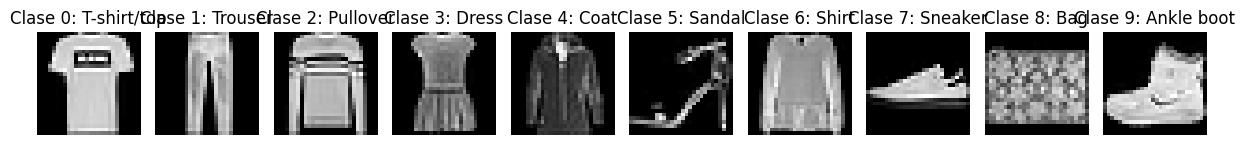

In [73]:
#Clases 
plt.figure(figsize=(12, 6))

# Etiquetas de las categorías
categories = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i in range(10):
    # Encontrar el primer ejemplo de la categoría actual
    example_index = np.where(y_train == i)[0][0]
    image = X_train[example_index].reshape(28, 28)  # Remodelar la imagen a 28x28

    # Configurar un subgráfico para cada categoría
    plt.subplot(1, 10, i + 1)  # 2 filas, 5 columnas
    plt.imshow(image, cmap='gray')
    plt.title(f'Clase {i}: {categories[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [74]:
# Parámetros
num_classes = 10  # Número de clases en FashionMNIST
input_dim = X_train.shape[1]  # Dimensión de entrada (28*28)
num_inducing = 300  # Número de puntos de inducción
batch_size = 1000   # Tamaño de lote para el entrenamiento

In [75]:
# Kernel RBF
kernel = gpflow.kernels.SquaredExponential()

# Modelo GPR
inducing_variable = X_train[:300]  # Usar 500 puntos de inducción
model = gpflow.models.SVGP(kernel=kernel,
                           likelihood=gpflow.likelihoods.MultiClass(10),
                           inducing_variable=inducing_variable,
                           num_latent_gps=10)
print('kernel hyperparameter initial point\n',model.kernel.lengthscales)

kernel hyperparameter initial point
 <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=1.0>


In [76]:
# Crear el dataset de entrenamiento con minibatches
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=X_train.shape[0])  # Mezclar los datos
train_dataset = train_dataset.batch(batch_size)  # Dividir en minibatches

In [77]:
# Definir el número de épocas y el optimizador
num_epochs = 100
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Inicializar una lista para almacenar las pérdidas
loss_history = []

# Función de optimización
@tf.function
def optimization_step(model, X_batch, Y_batch):    
    with tf.GradientTape() as tape:
        # Calcular la Evidencia Inferior del Logaritmo Marginal (ELBO)
        elbo = model.elbo((X_batch, Y_batch))
        loss = -elbo  # El objetivo es maximizar el ELBO, por lo que minimizamos su negativo
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [86]:
# Bucle de entrenamiento sin impresión
for epoch in range(num_epochs):
    for step, (X_batch, Y_batch) in enumerate(train_dataset):
        loss = optimization_step(model, X_batch, Y_batch)
        loss_value = loss.numpy()  # Convertir el tensor a un valor numérico
        loss_history.append(loss_value)  # Almacenar la pérdida


In [88]:
X_test_tensor = tf.convert_to_tensor(X_test)
mean, var = model.predict_y(X_test_tensor)
predictions = np.argmax(mean, axis=1)
accuracy = np.mean(predictions.reshape(-1, 1) == y_test)


In [89]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generar el informe de clasificación
report = classification_report(y_test, predictions, digits=4)
print("\nClassification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

           0     0.7454    0.8430    0.7912      1000
           1     0.9884    0.9350    0.9609      1000
           2     0.6992    0.7810    0.7378      1000
           3     0.8077    0.8860    0.8450      1000
           4     0.7485    0.7530    0.7507      1000
           5     0.9045    0.9000    0.9023      1000
           6     0.6976    0.4430    0.5419      1000
           7     0.8973    0.8910    0.8941      1000
           8     0.9071    0.9470    0.9266      1000
           9     0.8986    0.9310    0.9145      1000

    accuracy                         0.8310     10000
   macro avg     0.8294    0.8310    0.8265     10000
weighted avg     0.8294    0.8310    0.8265     10000



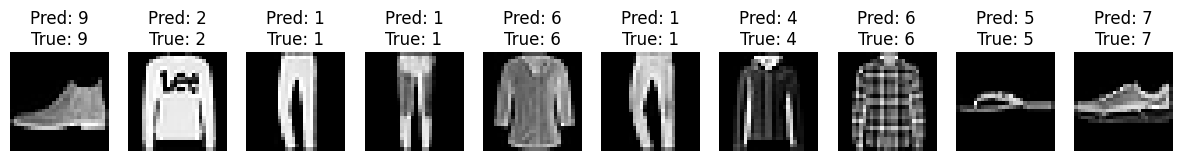

In [90]:
# Visualizar algunas imágenes con predicciones
num_images = 10
plt.figure(figsize=(15, 15))
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {predictions[i]}\nTrue: {y_test_labels[i]}")
    plt.axis('off')
plt.show()